# Digital Elevation Model of the Marche Region
In this notebook we plot the DEM of Marche, a region of Central Italy. We use the the [Tinitaly](http://tinitaly.pi.ingv.it/) DEM from INGV.

In [1]:
import os
import numpy as np
from osgeo import gdal, osr, ogr
import skimage
from skimage import io
from skimage import util
import matplotlib.pyplot as plt
import matplotlib as mpl
import warnings
warnings.filterwarnings('ignore')
print("numpy version: %s"%np.__version__)
print("GDAL version: %s"%gdal.__version__)

numpy version: 1.23.1
GDAL version: 3.5.1


In [2]:
#os.getcwd()
#os.chdir('..')

## Tinitaly DEM

2


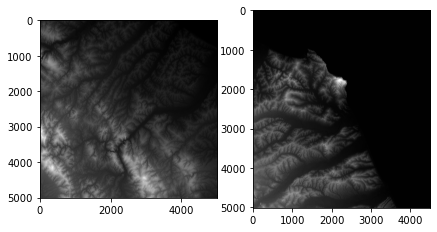

In [3]:
path = 'data/raster/italy/dem/tinitaly/'
dem1_path = path + 'w48080_s10.tif'
dem2_path = path + 'w48085_s10.tif'
img1 = io.imread(dem1_path)
img2 = io.imread(dem2_path)
print(img1.ndim)
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(7, 7))
axes[0].imshow(img1, cmap='gray')
axes[1].imshow(img2, cmap='gray')

We will use the values in the 2D array as a function of the coordinates z = f(x, y)

In [12]:
ds1 = gdal.Open(dem1_path, gdal.GA_ReadOnly)
band1 = ds1.GetRasterBand(1)
z1 = band1.ReadAsArray()
print("Band Type={}".format(gdal.GetDataTypeName(band1.DataType)))
band1.XSize, band1.YSize, band1.DataType, ds1.GetProjection()

Band Type=Float32


(5010,
 5010,
 6,
 'PROJCS["WGS 84 / UTM zone 32N",GEOGCS["WGS 84",DATUM["WGS_1984",SPHEROID["WGS 84",6378137,298.257223563,AUTHORITY["EPSG","7030"]],AUTHORITY["EPSG","6326"]],PRIMEM["Greenwich",0,AUTHORITY["EPSG","8901"]],UNIT["degree",0.0174532925199433,AUTHORITY["EPSG","9122"]],AUTHORITY["EPSG","4326"]],PROJECTION["Transverse_Mercator"],PARAMETER["latitude_of_origin",0],PARAMETER["central_meridian",9],PARAMETER["scale_factor",0.9996],PARAMETER["false_easting",500000],PARAMETER["false_northing",0],UNIT["metre",1,AUTHORITY["EPSG","9001"]],AXIS["Easting",EAST],AXIS["Northing",NORTH],AUTHORITY["EPSG","32632"]]')

In [13]:
ds2 = gdal.Open(dem2_path, gdal.GA_ReadOnly)
band2 = ds2.GetRasterBand(1)
z2 = band2.ReadAsArray()
print("Band Type={}".format(gdal.GetDataTypeName(band2.DataType)))
band2.XSize, band2.YSize, band2.DataType, ds2.GetProjection()

Band Type=Float32


(4505,
 5010,
 6,
 'PROJCS["WGS 84 / UTM zone 32N",GEOGCS["WGS 84",DATUM["WGS_1984",SPHEROID["WGS 84",6378137,298.257223563,AUTHORITY["EPSG","7030"]],AUTHORITY["EPSG","6326"]],PRIMEM["Greenwich",0,AUTHORITY["EPSG","8901"]],UNIT["degree",0.0174532925199433,AUTHORITY["EPSG","9122"]],AUTHORITY["EPSG","4326"]],PROJECTION["Transverse_Mercator"],PARAMETER["latitude_of_origin",0],PARAMETER["central_meridian",9],PARAMETER["scale_factor",0.9996],PARAMETER["false_easting",500000],PARAMETER["false_northing",0],UNIT["metre",1,AUTHORITY["EPSG","9001"]],AXIS["Easting",EAST],AXIS["Northing",NORTH],AUTHORITY["EPSG","32632"]]')

In [14]:
x_origin, x_pixel_resolution, row_rotation, y_origin, column_rotation, y_pixel_resolution = ds1.GetGeoTransform()
print('x_origin: {}, y_origin: {}, pixel resolution: {}'.format(x_origin, y_origin, x_pixel_resolution))

x_origin: 799950.0, y_origin: 4850050.0, pixel resolution: 10.0


In [15]:
min = band1.GetMinimum()
max = band1.GetMaximum()
if not min or not max:
    (min,max) = band1.ComputeRasterMinMax(True)
print("Min={:.3f}, Max={:.3f}".format(min,max))

Min=0.000, Max=1653.388


In [16]:
min = band2.GetMinimum()
max = band2.GetMaximum()
if not min or not max:
    (min,max) = band2.ComputeRasterMinMax(True)
print("Min={:.3f}, Max={:.3f}".format(min,max))

Min=-1.909, Max=510.005


We have to change the coordinate value from the image reference system to a georeferenced coordinate system (see [Geotransform tutorial](https://gdal.org/tutorials/geotransforms_tut.html#geotransforms-tut)).

In [9]:
geotransform1 = ds1.GetGeoTransform()
minx1 = geotransform1[0]
maxy1 = geotransform1[3]
maxx1 = minx1 + band1.XSize * geotransform1[1]
miny1 = maxy1 + band1.YSize * geotransform1[5]
x1 = np.arange(minx1, maxx1, geotransform1[1])
y1 = np.arange(maxy1, miny1, geotransform1[5])
x1, y1 = np.meshgrid(x1[:band1.XSize], y1[:band1.YSize])

In [10]:
geotransform2 = ds2.GetGeoTransform()
minx2 = geotransform2[0]
maxy2 = geotransform2[3]
maxx2 = minx2 + band2.XSize * geotransform2[1]
miny2 = maxy2 + band2.YSize * geotransform2[5]
x2 = np.arange(minx2, maxx2, geotransform2[1])
y2 = np.arange(maxy2, miny2, geotransform2[5])
x2, y2 = np.meshgrid(x2[:band2.XSize], y2[:band2.YSize])

(795198.0, 899742.0, 4797455.5, 4852554.5)

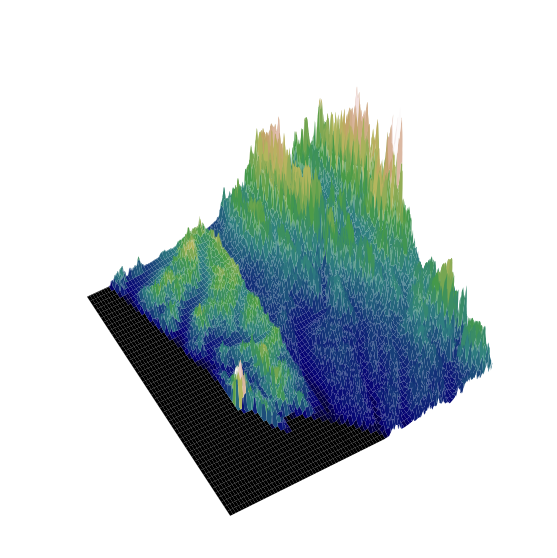

In [17]:
fig = plt.figure(1, figsize=(10, 10))
ax = plt.axes(projection='3d')
ax.plot_surface(x1, y1, data1, rstride=100, cstride=100, edgecolor='none', cmap='gist_earth', lw=1)
ax.plot_surface(x2, y2, data2, rstride=100, cstride=100, edgecolor='none', cmap='gist_earth', lw=1)
ax.view_init(elev=55, azim=60) # ground level -> elevation=0, from above -> elevation=90
plt.axis('off')

## Opentopography DEM

(5010, 5010)


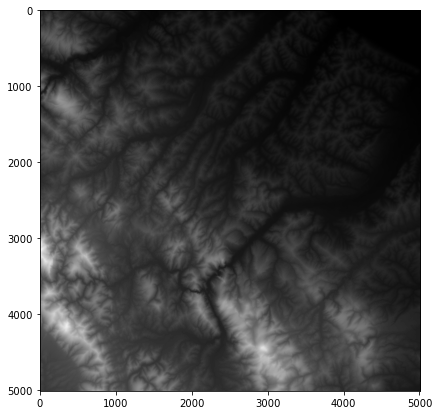

In [18]:
path = 'data/raster/italy/dem/opentopography/'
dem_path = path + 'output_COP30.tif'
img = io.imread(dem1_path)
print(img1.shape)
fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(7, 7))
ax.imshow(img1, cmap='gray')

In [112]:
from scipy import exp, mgrid, signal, row_stack, column_stack, tile, misc
def gaussian_blur(in_array, size):

    # expand in_array to fit edge of kernel, by repeating edge values
    ny, nx = in_array.shape
    ary = row_stack((tile(in_array[0,:], size).reshape((size, nx)),
                     in_array,
                     tile(in_array[-1,:], size).reshape((size, nx))))
    arx = column_stack((tile(ary[:,0], size).reshape((size, ny + size*2)).T,
                        ary,
                        tile(ary[:,-1], size).reshape((size, ny + size*2)).T))
    
    # build kernel
    x, y = mgrid[-size:size+1, -size:size+1]
    g = exp(-(2*x**2/float(size) + 2*y**2/float(size)))
    g = (g / g.sum()) #.astype(in_array.dtype)
    
    # do the gaussian blur over arx
    return signal.convolve(arx, g, mode='valid')

In [113]:
ds = gdal.Open(dem_path, gdal.GA_ReadOnly)
band = ds.GetRasterBand(1)
z_tmp1 = band.ReadAsArray()
z_tmp1b = gaussian_blur(z_tmp1/1000, 1001)
z_tmp1a = gaussian_blur(z_tmp1b/1000, 501)
z_tmp2a = gaussian_blur(z_tmp1a/1000, 201)
z_tmp2 = gaussian_blur(z_tmp2a/1000, 201)
z_tmp3 = gaussian_blur(z_tmp2/200, 201)
z_tmp4 = gaussian_blur(z_tmp3/10, 101)
z = gaussian_blur(z_tmp4, 101)
print("Band Type={}".format(gdal.GetDataTypeName(band.DataType)))
band.XSize, band.YSize, band.DataType, ds.GetProjection()

C:\Users\Luigi\AppData\Local\Temp\ipykernel_432\2687438907.py:6: DeprecationWarning: scipy.tile is deprecated and will be removed in SciPy 2.0.0, use numpy.tile instead
  ary = row_stack((tile(in_array[0,:], size).reshape((size, nx)),
C:\Users\Luigi\AppData\Local\Temp\ipykernel_432\2687438907.py:8: DeprecationWarning: scipy.tile is deprecated and will be removed in SciPy 2.0.0, use numpy.tile instead
  tile(in_array[-1,:], size).reshape((size, nx))))
C:\Users\Luigi\AppData\Local\Temp\ipykernel_432\2687438907.py:6: DeprecationWarning: scipy.row_stack is deprecated and will be removed in SciPy 2.0.0, use numpy.row_stack instead
  ary = row_stack((tile(in_array[0,:], size).reshape((size, nx)),
C:\Users\Luigi\AppData\Local\Temp\ipykernel_432\2687438907.py:9: DeprecationWarning: scipy.tile is deprecated and will be removed in SciPy 2.0.0, use numpy.tile instead
  arx = column_stack((tile(ary[:,0], size).reshape((size, ny + size*2)).T,
C:\Users\Luigi\AppData\Local\Temp\ipykernel_432\26874389

Band Type=Float32


(6803,
 5224,
 6,
 'GEOGCS["WGS 84",DATUM["WGS_1984",SPHEROID["WGS 84",6378137,298.257223563,AUTHORITY["EPSG","7030"]],AUTHORITY["EPSG","6326"]],PRIMEM["Greenwich",0],UNIT["degree",0.0174532925199433,AUTHORITY["EPSG","9122"]],AXIS["Latitude",NORTH],AXIS["Longitude",EAST],AUTHORITY["EPSG","4326"]]')

In [114]:
geotransform = ds.GetGeoTransform()
minx = geotransform[0]
maxy = geotransform[3]
maxx = minx + band.XSize * geotransform[1]
miny = maxy + band.YSize * geotransform[5]
x = np.arange(minx, maxx, geotransform[1])
y = np.arange(maxy, miny, geotransform[5])
x, y = np.meshgrid(x[:band.XSize], y[:band.YSize])

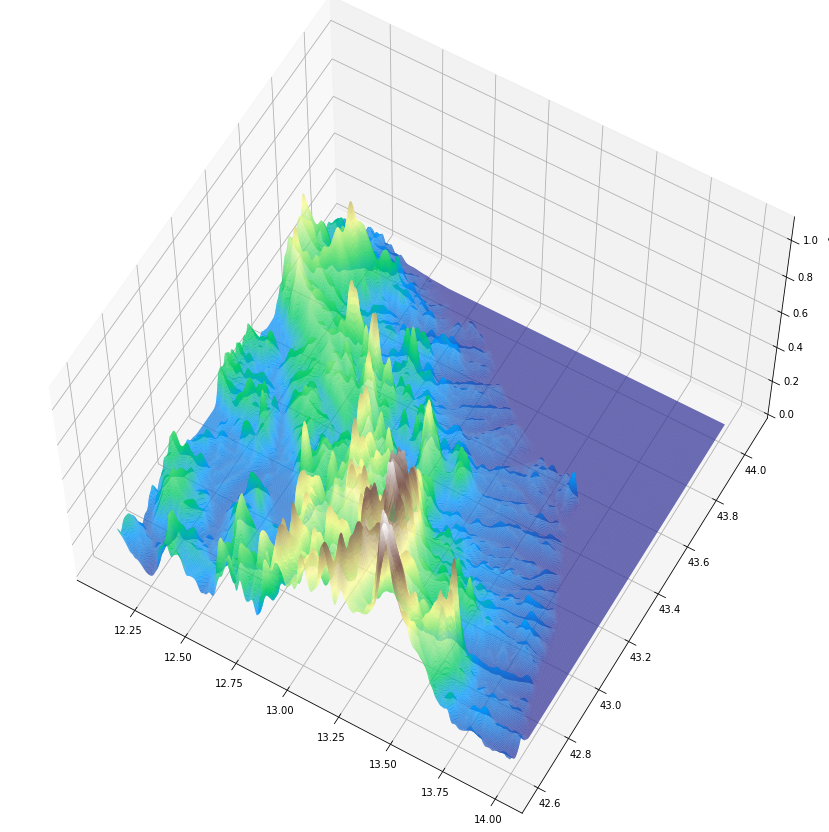

In [115]:
fig = plt.figure(1, figsize=(15, 15))
ax = plt.axes(projection='3d')
ax.plot_surface(x, y, z/10, rstride=10, cstride=10, edgecolor='none', cmap='terrain', lw=-100)
ax.view_init(elev=60, azim=-60) # ground level -> elevation=0, from above -> elevation=90
#plt.axis('off')

## References
* [EU-DEM](https://land.copernicus.eu/imagery-in-situ/eu-dem)

# Credits
Tarquini S., Isola I., Favalli M., Battistini A. (2007) TINITALY, a digital elevation model of Italy with a 10 m-cell size (Version 1.0) [Data set]. Istituto Nazionale di Geofisica e Vulcanologia (INGV). https://doi.org/10.13127/TINITALY/1.0.”